<a id='page-top'></a> <img src='../img/LogoLine_horizon_C3S.png' alt='Logo EU Copernicus ECMWF' align='right' width='100%'></img>

# How to access, read and process satellite XCO2 and XCH4 Level 3 data products

This is a Jupyter Notebook illustrating how to access, read and process Greenhouse Gas (GHG) carbon dioxide (CO2) and methane (CH4) data products as generated in the framework of the Copernicus Climate Change Service (C3S) project C3S2_312a_Lot2.

The data products are retrieved from satellite radiance measurements using appropriate retrieval algorithms. Most of these algorithms have been developed in the past within the Climate Change Initiative (CCI) of the European Space Agency (ESA). These algorithms are now used to operationally generate the corresponding data products within the European Union (EU) C3S project. The data products are freely available for all interested users from the Copernicus Climate Data Store (CDS,
https://cds.climate.copernicus.eu/).

In project C3S2_312a_Lot2 several satellite-derived Essential Climate Variable (ECV) atmospheric data products are generated for GHGs (CO2 and CH4), aerosols and ozone. This Jupyter Notebook (JN) focusses on GHG Level 3 (L3) products. The other products are covered by separate JNs. The L3 products are available at a spatial resolution of 5 deg latitude times 5 deg longitude and monthly time resolution. In contrast, Level 2 (L2) products contain retrieved parameters for individual satellite ground pixels (footprints). 

Here it will be shown how the L3 data products can be obtained from the CDS and how they can be processed to extract important information and how to visualize this information in the form of time series and spatial maps.

The L3 products are column-averaged dry-air mole fractions of CO2 and CH4, denoted XCO2 (in ppm) and XCH4 (in ppb). They are derived from SCIAMACHY/ENVISAT, GOSAT, GOSAT-2 and OCO-2. 

The relevant peer-reviewed publication describing the algorithm and an earlier version of the data products is Reuter et al., 2020 (https://amt.copernicus.org/articles/13/789/2020/). The relevant technical documentation and further information is available on the CDS website (https://cds.climate.copernicus.eu/).

The L3 XCO2 data product has the product identifier (ID) XCO2_OBS4MIPS and the L3 XCH4 product ID is XCH4_OBS4MIPS. Each product consists of a single NetCDF file in Obs4MIPs format (https://esgf-node.llnl.gov/projects/obs4mips/).

The code has been tested using the latest versions of the satellite data products, which at the time of writing is version 4.4, and covers the period from beginning of 2003 to end of 2021.

This document is provided “as is” and no guarantee of warranty is given that the content is fit for any particular purpose. The users thereof usethis document at their sole risk and liability.

## How to get the satellite data products:

Each satellite-derived CO2 or CH4 data product as generated in C3S project C3S2_312a_Lot2 has a unique product identifier (ID). The product IDs of the products used here are: XCO2_OBS4MIPS and XCH4_OBS4MIPS.

On the CDS website these products can be selected using "MERGED and OBS4MIPS" as explained below. 

Note that all other satellite-derived CO2 and CH4 products are Level 2 (L2) products. L2 products are not gridded (in contrast to the OBS4MIPS L3 products) but contain information for each single satellite footprint (ground pixel) which implies a different data format. How to read and use the L2 products is illustrated in a separate Jupyter Notebook (JN).

The XCO2_OBS4MIPS data product is a single file in NetCDF format. Also the XCH4_OBS4MIPS product is a single file and has essentially the same format as the XCO2_OBS4MIPS file (except that some variable names start with xch4 instead of xco2).

Arguably the easiest way to get the data is to download them from the CDS website by clicking on the relevant entries 
as provided via the CDS user interface. How to do this is explained in the following section.

### Data download via the CDS website:

Goto: 
    https://cds.climate.copernicus.eu/#!/home
    
In the following we explain how to obtain the XCO2_OBS4MIPS v4.4 product. Essentially the same method can be used to get the corresponding methane XCH4_OBS4MIPS v4.4 product.

Search for: CO2.

Then click on: 
- Carbon dioxide data from 2002 to present derived from satellite observations
- Download data

Then select:
- Level 3
- Column-average dry-air mole fraction of atmospheric Carbon Dioxide (XCO2) and related variables
- MERGED and OBS4MIPS
- 4.4
- Zip file (.zip)

Then: 
- Login/register to submit request (use "Create new account", if needed)
- Click on: Download
- Unzip the file and move it to the current directory.
- Add "XCO2_" at the beginning of the XCO2 filename and "XCH4_" at the beginning of the XCH4 filename.

Finally, the following two files should be located in the current directory:

XCO2_200301_202112-C3S-L3_GHG-GHG_PRODUCTS-MERGED-MERGED-OBS4MIPS-MERGED-v4.4.nc

XCH4_200301_202112-C3S-L3_GHG-GHG_PRODUCTS-MERGED-MERGED-OBS4MIPS-MERGED-v4.4.nc

## How to read and process the satellite data with Python:

In the following, Phython 3 code is provided to read and process the satellite data. 

It is assumed that Python and Jupyter Notebook (JN) is installed on your computer, e.g., using the Anaconda distribution (https://www.anaconda.com/products/distribution).

The code starts with importing several modules as needed to run this JN. See section "Imports".

## Imports:

In [1]:
import os
import os.path
from netCDF4 import Dataset
import datetime
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import juliandate as jd

## Initial user input:

In [2]:
# Select one main_product:
#main_product = 'XCO2'
main_product = 'XCH4'

# Set input file names, product ID and version number:
if main_product == 'XCO2':
   in_file     = 'XCO2_200301_202112-C3S-L3_GHG-GHG_PRODUCTS-MERGED-MERGED-OBS4MIPS-MERGED-v4.4.nc'
   product_ver = 'XCO2_OBS4MIPS v4.4' 
if main_product == 'XCH4':
   in_file     = 'XCH4_200301_202112-C3S-L3_GHG-GHG_PRODUCTS-MERGED-MERGED-OBS4MIPS-MERGED-v4.4.nc'
   product_ver = 'XCH4_OBS4MIPS v4.4' 
    
print('* main_product: ', main_product)

* main_product:  XCH4


## Initial settings:

In [3]:
# Set units etc.:
if main_product == 'XCO2':
   xghg_unit  = 'ppm'
   xghg_str   = 'Carbon dioxide'
   xghg_str1  = 'XCO$_2$'
   xghg_str2  = 'Column-averaged CO$_2$, XCO$_2$ [ppm]'
if main_product == 'XCH4':
   xghg_unit  = 'ppb'
   xghg_str   = 'Methane'
   xghg_str1  = 'XCH$_4$'
   xghg_str2  = 'Column-averaged CH$_4$, XCH$_4$ [ppb]'
    
sns.set() # seaborn style for plots

# Select:
plot_type = 'png'
#plot_type = 'screen'

## Functions:

In [4]:
# Convert OBS4MIPS start time (first dim of time_bnds) into year and month
# Input:  o4m_start_time: month start time in days since 01-01-1990
# Output: year and month for each time index (two 1D arrays with same length as o4m_start_time)
def get_year_month_from_o4m_time(o4m_start_time):
   #import datetime
   #import math
   #import numpy as np
   o4m_year  = None
   o4m_month = None
   o4m_start_time_np = np.array(o4m_start_time)
   n_times = len(o4m_start_time_np)
   #print('* n_times: ', n_times)
   jd2_ref = jd.from_gregorian(1990, 1, 1)
   data_ok = 1     # Assume all is OK
   n_ok    = 0
   if n_times > 0:
      pass
      year  = []
      month = []
      # ----------------------------------
      for ii in range(n_times):
         if 1 == 1:
            act_time   = o4m_start_time_np[ii]
            time_grego = jd2_ref + act_time + 15
            act_date   = jd.to_gregorian(time_grego)
            act_year   = act_date[0]
            act_month  = act_date[1]
            #gre_cmp = jd.from_gregorian(act_year, act_month, 1)
            #print('* ii act_time yy mm: ', ii, act_time, act_year, act_month)
            if 1 == 1:
               n_ok    = n_ok + 1
               year.append(act_year)
               month.append(act_month)
      # ----------------------------------
      if n_ok != n_times:
         data_ok = 0
      if 1 == 1:
         # generate output arrays if all OK:
         if (data_ok == 1):
            year  = np.array(year)
            month = np.array(month)
            o4m_year  = year
            o4m_month = month
         else:
            print('* ERROR in get_year_month_from_o4m_time: unexpected issue: cannot generate year and month arrays')
   return o4m_year, o4m_month

In [5]:
# Read input data:
# Input: (main_product = 'XCO2' or 'XCH4') and OBS4MIPS file name
# Output: see below
# Note: Listed numerical values for illustration only 
def read_o4m_file(main_product, in_file):
   print('* read_o4m_file: Trying to read: ', in_file)
   # Init output:
   xghg          = None # XCO2 (in ppm) or XCH4 (in ppb) in cell
   xghg_unc      = None # 1-sigma uncertainty (in ppm or ppb)
   lat           = None # Cell center latitude
   lon           = None # Cell center longitude
   year          = None # Year
   month         = None # Month
   nobs          = None # Number of underlying single observations (can be 0!)
   land_fraction = None # Fraction of cell covered by land
   c_fac = 0.0
   if (os.path.exists(in_file) == True):
      print('* ... reading ...')
      in_file_OK = 1
      ds = Dataset(in_file)
      ds.set_auto_mask(False) # then missing values = '--' are 0 (nobs !)
      all_lat  = ds.variables['lat'][:]  # 1D: -87.5 -82.5 ...
      all_lon  = ds.variables['lon'][:]  # 1D -177.5 -172.5 ...
      #all_time = ds.variables['time'][:] # 1D: days since 01-01-1990: 4763.5 4793.0 ...
      all_time_bnds  = ds.variables['time_bnds'][:] # 2D: time boundaries
      all_time_start = all_time_bnds[:,0] # day number of first day of each month
      #all_time_end   = all_time_bnds[:,1] # day number of last day of each month
      #nal_lat  = len(all_lat);   print('* nal_lat: ', nal_lat)   # 36
      #nal_lon  = len(all_lon);   print('* nal_lon: ', nal_lon)   # 72
      #nal_time = len(all_time);  print('* nal_time: ', nal_time) # 228
      #del_lat = 180.0 / nal_lat; print('* del_lat: ', del_lat)   # 5 deg
      #del_lon = 360.0 / nal_lon; print('* del_lon: ', del_lon)   # 5 deg
      #n_years = nal_time / 12.0; print('* n_years: ', n_years)   # 19
      all_year, all_month = get_year_month_from_o4m_time(all_time_start)
      all_land_fraction = ds.variables['land_fraction']
      if 1 == 1:
         # ------------------------------
         if main_product == 'XCO2':
            all_xghg = ds.variables['xco2']                 # xco2(time,lat,lon)
            #print('* all_xghg.shape: ', all_xghg.shape)    # (228, 36, 72)
            all_nobs          = ds.variables['xco2_nobs']   # Number of used observations in cell
            all_xghg_unc      = ds.variables['xco2_stderr'] # 1-sigma uncertainty
            all_xghg_std      = ds.variables['xco2_stddev'] # StdDev of used observations in cell
            c_fac = 1e6                                     # To convert mixing ratio to ppm
         # ------------------------------
         if main_product == 'XCH4':
            all_xghg = ds.variables['xch4']                 # xch4(time,lat,lon)
            #print('* all_xghg.shape: ', all_xghg.shape)    # (228, 36, 72)
            all_nobs          = ds.variables['xch4_nobs']   # Number of used observations in cell
            all_xghg_unc      = ds.variables['xch4_stderr'] # 1-sigma uncertainty
            all_xghg_std      = ds.variables['xch4_stddev'] # StdDev of used observations in cell
            c_fac = 1e9                                     # To convert mixing ratio to ppb
         # ------------------------------
   else:
       print('* read_o4m_file: ERROR: input file does not exist !')
       in_file_OK = 0
   if 1 == 1:
      if in_file_OK == 1:
         xghg          = np.array(all_xghg)
         xghg_unc      = np.array(all_xghg_unc)
         xghg          = xghg * c_fac # convert to ppm or ppb
         xghg_unc      = xghg_unc * c_fac
         lat           = np.array(all_lat)
         lon           = np.array(all_lon)
         year          = np.array(all_year)
         month         = np.array(all_month)
         nobs          = np.array(all_nobs)
         land_fraction = np.array(all_land_fraction)
         ds.close()
   return xghg, xghg_unc, lat, lon, year, month, nobs, land_fraction

## Read OBS4MIPS file:

In [6]:
# Read OBS4MIPS file:
read_o4m_file_OK = 0
missing_val = 1e10 # keep
if 1 == 1:
   xghg, xghg_unc, lat, lon, year, month, nobs, land_fraction = read_o4m_file(main_product, in_file)
   if xghg is None:
      print('* ERROR: Issues reading satellite input data !')
   else:
      read_o4m_file_OK = 1
   if ((1 == 0) & (read_o4m_file_OK == 1)):
      print('* Array dimensions:')
      print('* xghg.shape: ', xghg.shape)
      print('* nobs.shape: ', nobs.shape)
      print('* year.shape: ', year.shape)
      print('* lat.shape: ',  lat.shape)
      print('* lon.shape: ',  lon.shape)
      print('* land_fraction.shape: ', land_fraction.shape)

* read_o4m_file: Trying to read:  XCH4_200301_202112-C3S-L3_GHG-GHG_PRODUCTS-MERGED-MERGED-OBS4MIPS-MERGED-v4.4.nc
* ... reading ...


## Compute and plot time series:

* generating:  XCH4_OBS4MIPS_timeseries.png


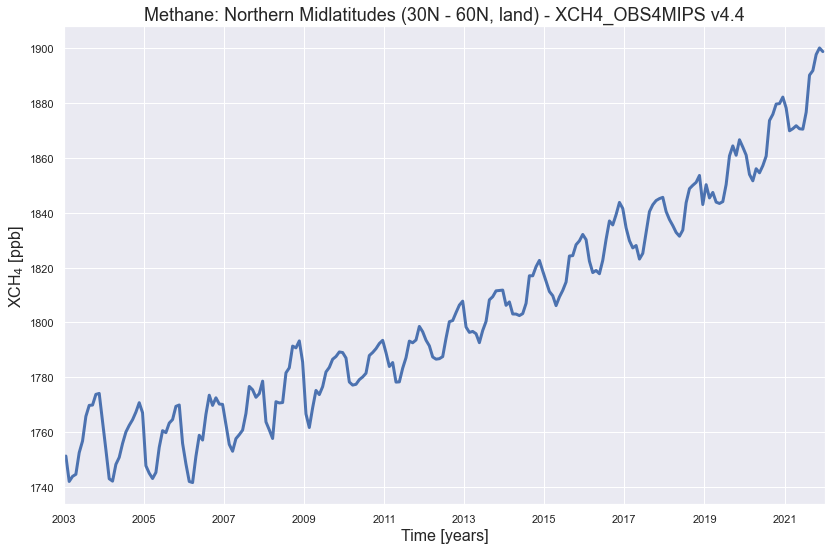

In [7]:
# Compute time series:
#
# Select latitude band etc.:
#lat_min = -90.0; lat_max = 90.0; min_land_fraction = 0.95; lat_str = 'Global (90S - 90N, land)'
lat_min = 30.0; lat_max = 60.0; min_land_fraction = 0.95; ts_str = 'Northern Midlatitudes (30N - 60N, land)'
#
if ((1 == 1) & (read_o4m_file_OK == 1)):
   n_times = len(year)
   ts_year  = []
   ts_month = []
   ts_xghg  = []
   #n_times = 145 # test
   #n_times = 2   # test
   n_cnt = 0
   ts_ok = 1 # Assume time series OK
   for ii in range(n_times):
      idx_time  = ii
      act_year  = year[ii]
      act_month = month[ii]
      #print('* ii act_year act_month: ', ii, act_year, act_month)
      xghg_act  = xghg[ii, :, :] # (36, 72); xghg.shape = (228, 36, 72)
      idx_lat   = np.where((lat >= lat_min) & (lat <= lat_max))
      xghg_tmp1 = xghg_act[idx_lat, :]
      lf_tmp1   = land_fraction[idx_lat, :]
      idx_good  = np.where((xghg_tmp1 < missing_val) & (lf_tmp1 >= min_land_fraction))
      #idx_good  = np.where((xghg_tmp1 < missing_val))
      #len_idx_good = len(idx_good)
      #print('* len_idx_good: ', len_idx_good)
      if (np.any(idx_good)):
         xghg_tmp2 = xghg_tmp1[idx_good]
         xghg_median = np.median(xghg_tmp2)
         ts_year.append(act_year)
         ts_month.append(act_month)
         ts_xghg.append(xghg_median)
         n_cnt = n_cnt + 1
   if n_cnt > 0:
      if 1 == 1:
         ts_year  = np.array(ts_year)
         ts_month = np.array(ts_month)
         ts_xghg  = np.array(ts_xghg)
         ts_fyear = ts_year + (ts_month-0.5)/12.0 # time in fractional years (approx.)
   else:
      print('* ERROR computing time series: No data found !')
      ts_ok = 0

   # Plot time series
   if 1 == 1:
      if ts_ok == 1:
         xxx = ts_fyear
         yyy = ts_xghg
         x_min   = np.min(ts_year)
         x_max   = np.max(ts_year)+1
         x_ticks = x_max - x_min
         if 1 == 1:
            #figsize = (8,5)
            figsize = (12,8)
            fig = plt.figure(figsize=figsize)
            pos = [0.10,0.11,0.88,0.83]     # pos (l,b,w,h) in page coord
            ax  = fig.add_axes(pos)
         else:
            fig, ax = plt.subplots()
         ax.plot(xxx, yyy, linewidth=3.0)
         ax.set(xlim=(x_min, x_max), xticks=np.arange(x_min, x_max, 2))
         title = xghg_str+': '+ts_str+' - '+product_ver
         x_label = 'Time [years]'
         y_label = xghg_str1+' ['+xghg_unit+']'
         plt.title(title, fontsize=18); plt.xlabel(x_label, fontsize=16); plt.ylabel(y_label, fontsize=16)
         if plot_type == 'png':
            o_file_plot = main_product+'_OBS4MIPS_timeseries.png'
            print('* generating: ', o_file_plot)
            plt.savefig(o_file_plot, dpi=600)
         else:
            plt.show()

What does this time series tells us?: Copernicus issued a press release in January 2023 where these XCO2 and XCH4 data sets have been used: "Copernicus: 2022 was a year of climate extremes, with record high temperatures and rising concentrations of greenhouse gases", see https://climate.copernicus.eu/copernicus-2022-was-year-climate-extremes-record-high-temperatures-and-rising-concentrations. Please have to look at that website to get information about the evolution of atmospheric CO2 and XCH using these satellite observations including links to relevant scientific publications.

## Monthly data on world map

* generating:  XCH4_OBS4MIPS_cmap.png


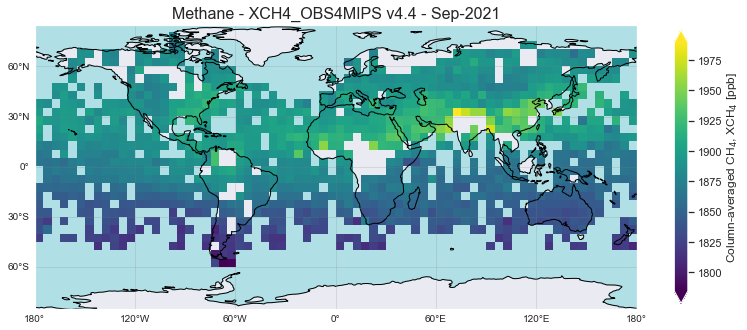

In [8]:
# Generate map and plot it using imshow
if ((1 == 1) & (read_o4m_file_OK == 1)):
   # Select year and month:
   #wanted_year  = 2004
   wanted_year  = 2021
   #wanted_month = 1;    wanted_month_str = 'Jan'
   wanted_month = 9;    wanted_month_str = 'Sep'
   #
   wanted_year_str = str(wanted_year)
   title = xghg_str+' - '+product_ver+' - '+wanted_month_str+'-'+wanted_year_str
   
   min_land_fraction = 0.0
   
   xghg_unc_OK = 0
   title_unc = 'Uncertainty - '+product_ver+' - '+wanted_month_str+'-'+wanted_year_str
   
   if 1 == 1:
      lonmin = -179.0
      lonmax =  179.0
      latmin =  -85.0
      latmax =   85.0
   else:
      lonmin = -30.0
      lonmax =  80.0
      latmin =  10.0
      latmax =  70.0
   
   # Get time index:
   idx_time = np.where((year == wanted_year) & (month == wanted_month))
   len_idx_time = len(idx_time)
   #
   # If OK, then proceed:
   if len_idx_time == 1:
      # Get global map for selected year and month;
      idx_time0 = idx_time[0][0]
      map_xghg_all     = xghg[idx_time0, :, :] 
      map_xghg_unc_all = xghg_unc[idx_time0, :, :] 
      # Reduce to selected region:
      if 1 == 1:
         idx_lat = np.where((lat >= latmin) & (lat <= latmax))
         idx_lon = np.where((lon >= lonmin) & (lon <= lonmax))
         lat_red  = lat[idx_lat]
         lon_red  = lon[idx_lon]
         xghg_red     = map_xghg_all[idx_lat[0][0]:idx_lat[0][-1]+1, idx_lon[0][0]:idx_lon[0][-1]+1]
         xghg_unc_red = map_xghg_unc_all[idx_lat[0][0]:idx_lat[0][-1]+1, idx_lon[0][0]:idx_lon[0][-1]+1]
      idx_good = np.where(xghg_red < missing_val)
      # --------------------------
      # XGHG:
      tmp1 = xghg_red[idx_good]
      xghg_median = int(np.median(tmp1))
      xghg_std    = int(np.std(tmp1))
      rcen = xghg_median
      rmin = rcen - 4*xghg_std
      rmax = rcen + 4*xghg_std
      idx_bad  = np.where(xghg_red > missing_val)
      xghg_red[idx_bad] = np.nan # fill missing values with NaNs
      # --------------------------
      # XGHG uncertainty:
      tmp2 = xghg_unc_red[idx_good]
      xghg_unc_median = int(np.median(tmp2))
      rmin_unc = 0
      rmax_unc = 2*xghg_unc_median
      xghg_unc_red[idx_bad] = np.nan # fill missing values with NaNs
      xghg_unc_OK = 1
      # --------------------------
      # --------------------------------------
      projection = ccrs.PlateCarree()
      if 1 == 1:
         figsize = (11,5)
         fig = plt.figure(figsize=figsize)
         pos = [0.08,0.02,0.95,0.95]     # pos (l,b,w,h) in page coord
         ax1  = fig.add_axes(pos, projection=projection)
         #ax1 = fig.add_subplot(1,1,1, projection=projection) # 'GeoAxesSubplot' object
         #ax1.set_position(pos=pos)
         ax1.coastlines(color='black')
         ax1.add_feature(cfeature.OCEAN, color='powderblue')
         if 1 == 1:
            drawmeridians_label = True
            gl = ax1.gridlines(crs=projection, draw_labels=drawmeridians_label, linewidth=1, color='gray', alpha=0.2)
            #gl.xlabels_top = False
            gl.top_labels   = False
            gl.right_labels = False
         levels = np.linspace(rmin, rmax, 100, endpoint=False)
         lat1 = lat_red
         lon1 = lon_red
         dat1 = xghg_red
         if 1 == 1:
            # Expand region (cell center coords -> cell edge coords):
            dd = (lat1[1] - lat1[0]) * 0.5
            lomi = lon1.min() - dd
            loma = lon1.max() + dd
            lami = lat1.min() - dd
            lama = lat1.max() + dd
            dat1_trans = np.flipud(dat1)
            im=plt.imshow(dat1_trans, cmap=plt.cm.viridis, extent=[lomi, loma, lami, lama])
         else:
            im = ax1.contourf(lon1, lat1, dat1, levels=levels, transform=projection, cmap='viridis', extend='both')
         plt.title(title, fontsize=16)
      # --------------------------------------
      do_cb = 1
      if do_cb == 1:
         #cbar = plt.colorbar(im, extend='both', location='bottom', shrink=0.4)
         cbar = plt.colorbar(im, extend='both', location='right', shrink=0.8)
         #cbar = plt.colorbar(im, ax=ax)
         #cbar.set_label('# of contacts', rotation=270)
         cbar.set_label(xghg_str2)
      if 1 == 1:
         #plot_type = 'screen'
         if plot_type == 'png':
            o_file_plot = main_product+'_OBS4MIPS_cmap.png'
            print('* generating: ', o_file_plot)
            plt.savefig(o_file_plot, dpi=600)
         else:
            plt.show()
   else:
      print('* ERROR: Cannot plot map: issue related to idx_time')

* generating:  XCH4_uncertainty_OBS4MIPS_cmap.png


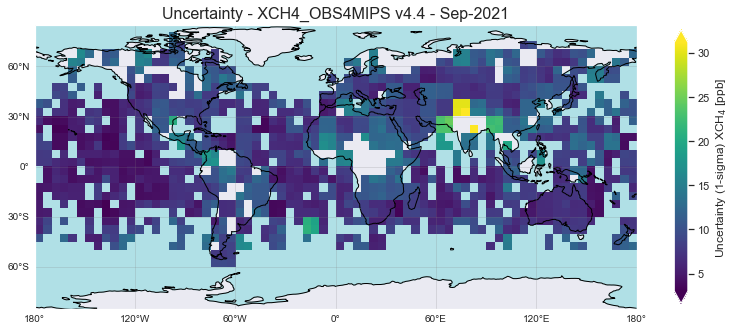

In [9]:
# Plot uncertainty:
if 1 == 1:
   if xghg_unc_OK == 1:
      if 1 == 1:
         #figsize = (11,5)
         fig = plt.figure(figsize=figsize)
         #pos = [0.08,0.02,0.95,0.95]     # pos (l,b,w,h) in page coord
         ax1  = fig.add_axes(pos, projection=projection)
         ax1.coastlines(color='black')
         ax1.add_feature(cfeature.OCEAN, color='powderblue')
         if 1 == 1:
            drawmeridians_label = True
            gl = ax1.gridlines(crs=projection, draw_labels=drawmeridians_label, linewidth=1, color='gray', alpha=0.2)
            gl.top_labels   = False
            gl.right_labels = False
         levels = np.linspace(rmin_unc, rmax_unc, 100, endpoint=False)
         dat1_unc = xghg_unc_red
         if 1 == 1:
            dat1_unc_trans = np.flipud(dat1_unc)
            im=plt.imshow(dat1_unc_trans, cmap=plt.cm.viridis, extent=[lomi, loma, lami, lama])
         plt.title(title_unc, fontsize=16)
      # --------------------------------------
      do_cb = 1
      if do_cb == 1:
         cbar = plt.colorbar(im, extend='both', location='right', shrink=0.8)
         cbar.set_label('Uncertainty (1-sigma) '+xghg_str1+' ['+xghg_unit+']')
      if 1 == 1:
         #plot_type = 'screen'
         if plot_type == 'png':
            o_file_plot_unc = main_product+'_uncertainty_OBS4MIPS_cmap.png'
            print('* generating: ', o_file_plot_unc)
            plt.savefig(o_file_plot_unc, dpi=600)
         else:
            plt.show()